In [1]:
import meshio
import numpy as np
from dolfinx import mesh, fem
from mpi4py import MPI
import basix
import pyvista as pv
from dolfinx.io import XDMFFile

[wifi-10-41-173-39.wifi.berkeley.edu:14498] shmem: mmap: an error occurred while determining whether or not /var/folders/hj/g_ncdftd5lncyq_628n7jckw0000gn/T//ompi.wifi-10-41-173-39.501/jf.0/1977679872/sm_segment.wifi-10-41-173-39.501.75e10000.0 could be created.


In [3]:
%pip install tetgen pyvista

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tetgen: filename=tetgen-0.6.5-cp313-cp313-macosx_10_13_x86_64.whl size=476464 sha256=af650cf3d72a4c2b30bc53e194cf740281019b2015a816cd200656079a57a3a9
  Stored in directory: /Users/rgopalam/Library/Caches/pip/wheels/5e/65/04/c2b61fbf312cdbab142267acf220dfbbc16a467dca96b53715
Successfully built tetgen
Note: you may need to restart the kernel to use updated packages.


pitch: [0.1 0.1 0.1] <class 'trimesh.caching.TrackedArray'>


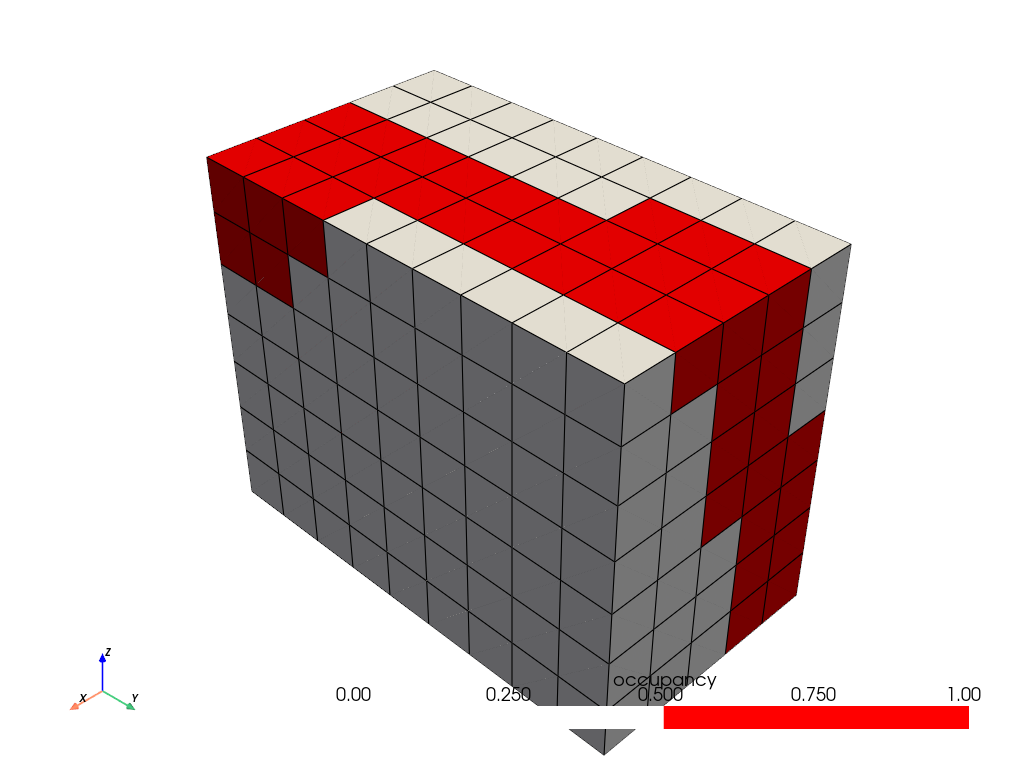

In [8]:
import numpy as np
import pyvista as pv
import trimesh

mesh = trimesh.load('test.stl')
voxel_size = 0.1
voxel_grid = mesh.voxelized(pitch=voxel_size)

occupancy = voxel_grid.matrix
origin = voxel_grid.bounds[0]

# Check the nature of voxel_grid.pitch
pitch_val = voxel_grid.pitch
print("pitch:", pitch_val, type(pitch_val))

# If it's a single float or single-element array:
if isinstance(pitch_val, np.ndarray):
    if pitch_val.size == 1:
        pitch = float(pitch_val.item())
        grid_spacing = (pitch, pitch, pitch)
    else:
        # Multiple values, assume this is a 3-element spacing
        grid_spacing = tuple(map(float, pitch_val))
else:
    # If it's already a float
    grid_spacing = (float(pitch_val), float(pitch_val), float(pitch_val))

X, Y, Z = occupancy.shape
grid = pv.ImageData()
grid.dimensions = (X+1, Y+1, Z+1)
grid.origin = origin
grid.spacing = grid_spacing

values = occupancy.astype(np.uint8).ravel(order='F')
grid.cell_data["occupancy"] = values

plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, scalars="occupancy", cmap=["white", "red"])
plotter.add_axes()
plotter.show()


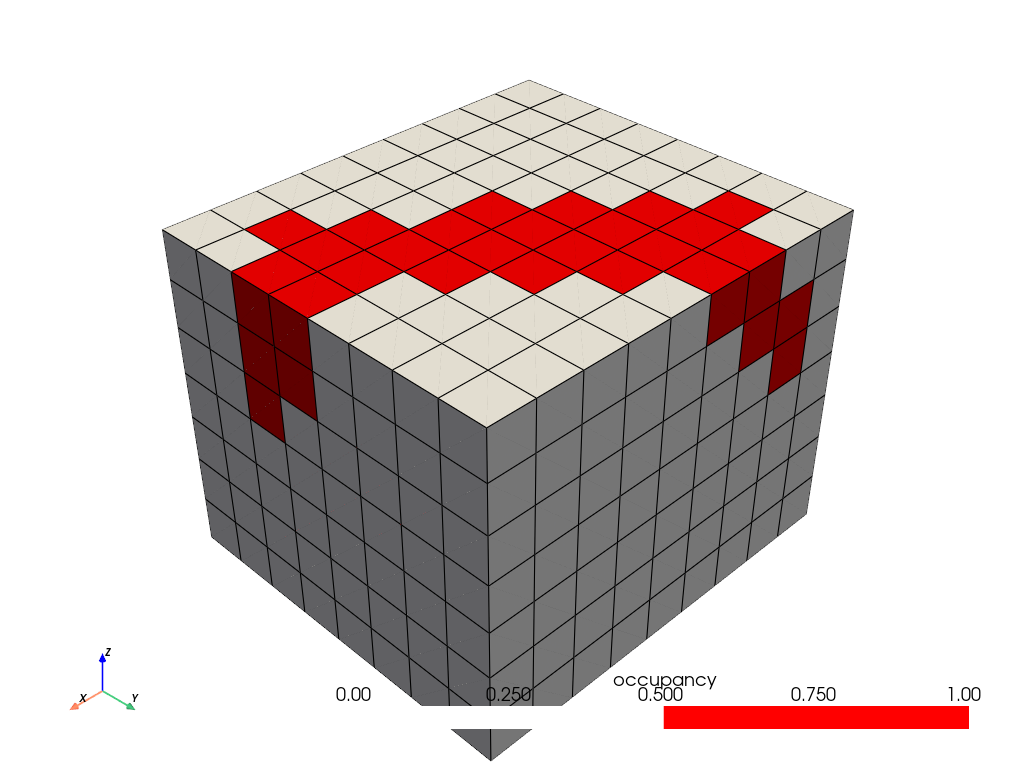

In [10]:
import trimesh
import numpy as np
import pyvista as pv

# Load the STL file
mesh = trimesh.load('test.stl')

# Rotate 45 degrees about the Z-axis
angle = np.deg2rad(45)
rotation_matrix = trimesh.transformations.rotation_matrix(angle, [0, 0, 1])
mesh.apply_transform(rotation_matrix)

# Voxelize the rotated mesh
voxel_grid = mesh.voxelized(pitch=0.1)

# Extract occupancy (X, Y, Z) boolean array
occupancy = voxel_grid.matrix

# Determine the grid's origin and spacing
origin = voxel_grid.bounds[0]  # (x_min, y_min, z_min)
pitch = voxel_grid.pitch       # Should be a scalar or single-value array

# If pitch is a single-element array, convert it to float
if isinstance(pitch, np.ndarray):
    if pitch.size == 1:
        pitch = float(pitch.item())
    else:
        # If for some reason it's a vector, just take all three
        pitch = float(pitch[0])  # or handle accordingly if anisotropic

X, Y, Z = occupancy.shape

# Create an ImageData object for visualization
grid = pv.ImageData()
grid.dimensions = (X+1, Y+1, Z+1)
grid.origin = origin
grid.spacing = (pitch, pitch, pitch)

# Convert occupancy to integers
values = occupancy.astype(np.uint8).ravel(order='F')
grid.cell_data["occupancy"] = values

# Set up the plotter and add the voxel grid
plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, scalars="occupancy", cmap=["white", "red"])
plotter.add_axes()
plotter.show()


In [6]:
import numpy as np
import meshio
from dolfinx.io import XDMFFile
from mpi4py import MPI

# Specify the XDMF file name
xdmf_file = "converted_mesh.xdmf"

# Map cell types if needed
cell_type_map = {
    np.uint8(10): "tetra",  # Replace "tetra" with the actual type if different
}

# Convert meshio cells to the XDMF format
cells = []
for cell_type, cell_data in mesh_data.cells_dict.items():
    cell_type_str = cell_type_map.get(cell_type, cell_type)
    if not cell_type_str:
        raise ValueError(f"Unknown cell type: {cell_type}. Please map it manually.")
    cells.append((cell_type_str, cell_data))

# Write the XDMF file
meshio.write_points_cells(
    xdmf_file,
    mesh_data.points,
    cells,
    file_format="xdmf",
)

# Load the XDMF file into DOLFINx
with XDMFFile(MPI.COMM_WORLD, xdmf_file, "r") as xdmf:
    domain_mesh = xdmf.read_mesh(name="Grid")  # Ensure the grid name matches the XDMF file
    print(f"Loaded mesh: {domain_mesh.topology.index_map(3).size_local} cells")



NameError: name 'mesh_data' is not defined

In [6]:
from mpi4py import MPI




x_min = domain_mesh.geometry.x[:, 0].min()
x_max = domain_mesh.geometry.x[:, 0].max()

y_min = domain_mesh.geometry.x[:, 1].min()
y_max = domain_mesh.geometry.x[:, 1].max()

z_min = domain_mesh.geometry.x[:, 2].min()
z_max = domain_mesh.geometry.x[:, 2].max()

x_mid = 0.5 * (x_min + x_max)
y_mid = 0.5 * (y_min + y_max)
z_mid = 0.5 * (z_min + z_max)

domain_mesh.geometry.x[:, 0] -= x_mid
domain_mesh.geometry.x[:, 1] -= y_mid
domain_mesh.geometry.x[:, 2] -= z_mid

# Recompute bounds
x_min = domain_mesh.geometry.x[:, 0].min()
x_max = domain_mesh.geometry.x[:, 0].max()

y_min = domain_mesh.geometry.x[:, 1].min()
y_max = domain_mesh.geometry.x[:, 1].max()

z_min = domain_mesh.geometry.x[:, 2].min()
z_max = domain_mesh.geometry.x[:, 2].max()

if MPI.COMM_WORLD.rank == 0:
    print(f"Mesh centered around origin:")
    print(f"X: [{x_min}, {x_max}]")
    print(f"Y: [{y_min}, {y_max}]")
    print(f"Z: [{z_min}, {z_max}]")


if MPI.COMM_WORLD.rank == 0:
    print(f"Mesh bounds:")
    print(f"X: [{x_min}, {x_max}]")
    print(f"Y: [{y_min}, {y_max}]")
    print(f"Z: [{z_min}, {z_max}]")


Mesh centered around origin:
X: [-0.21324491500854492, 0.21324491500854492]
Y: [-0.39824867248535156, 0.39824867248535156]
Z: [-0.34685420989990234, 0.34685420989990234]
Mesh bounds:
X: [-0.21324491500854492, 0.21324491500854492]
Y: [-0.39824867248535156, 0.39824867248535156]
Z: [-0.34685420989990234, 0.34685420989990234]


Layer: 0


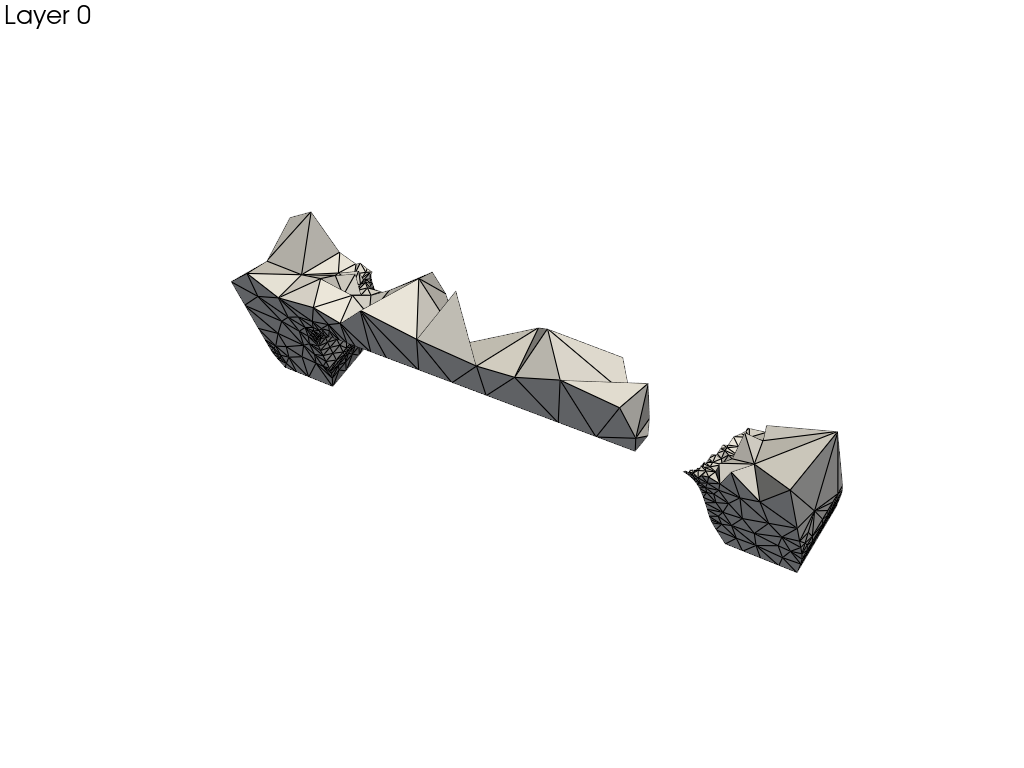

Layer: 1


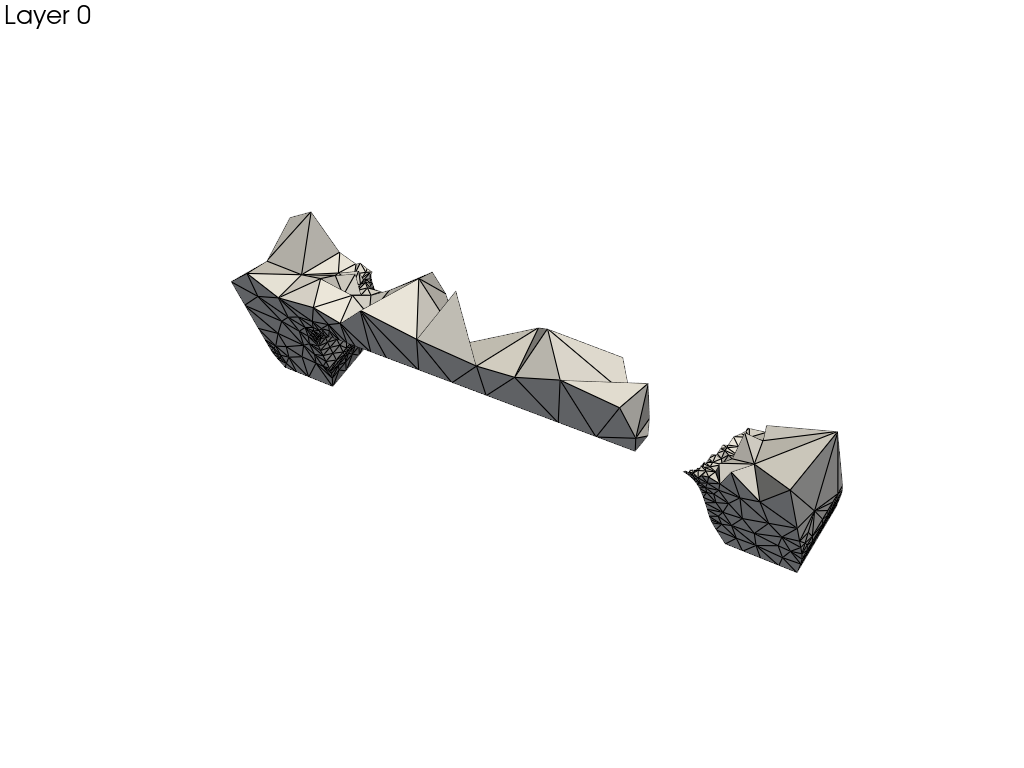

Layer: 2


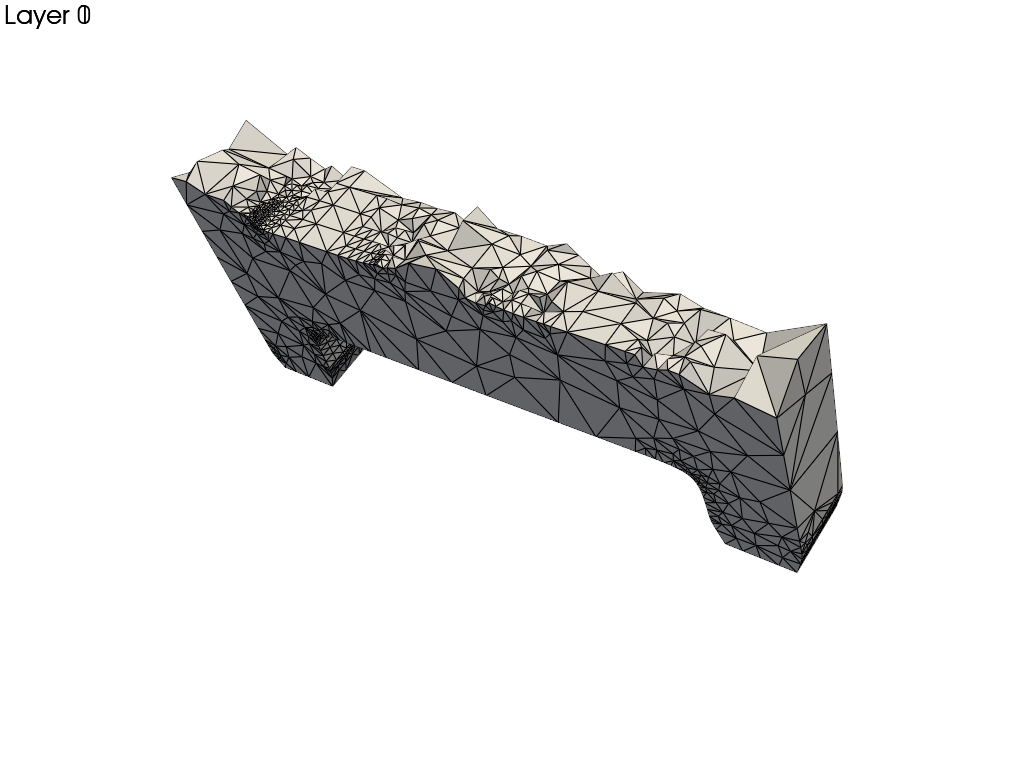

Layer: 3


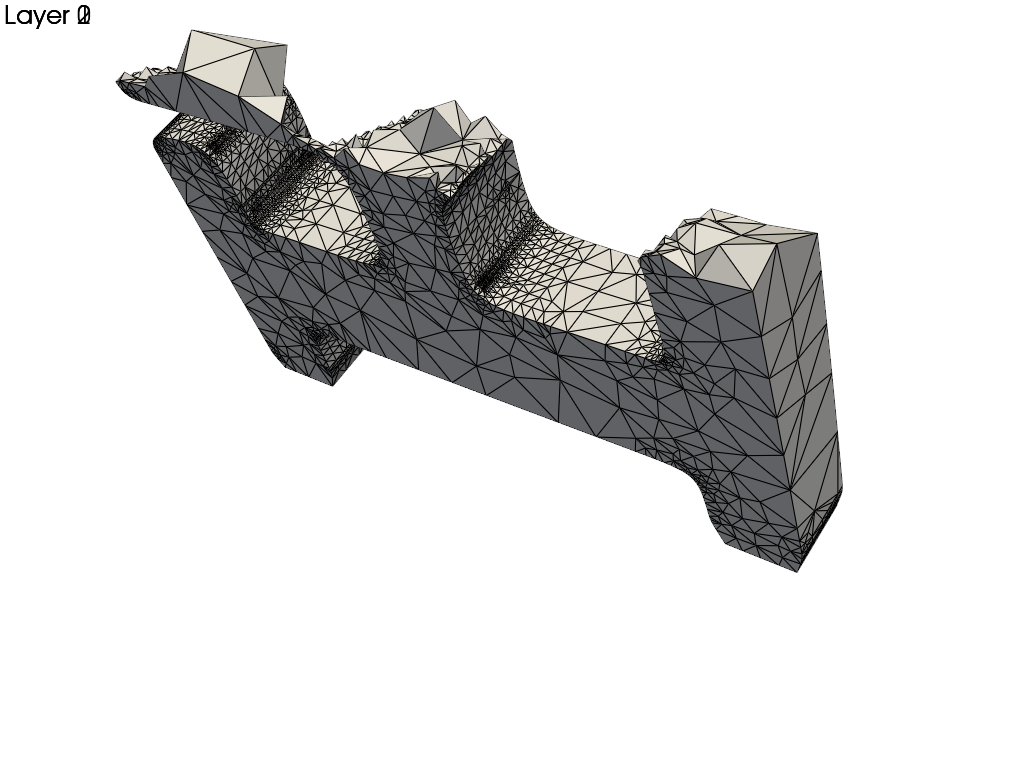

Layer: 4


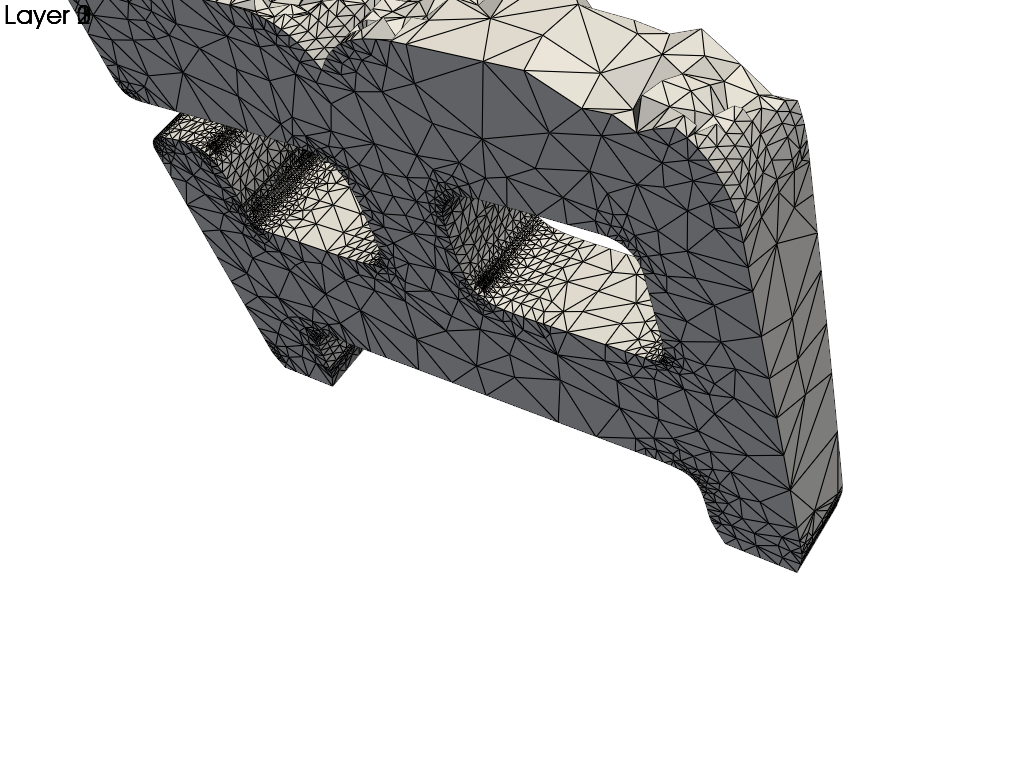

In [8]:
import pyvista as pv
from dolfinx.plot import vtk_mesh
import numpy as np

# Convert Dolfinx mesh to PyVista UnstructuredGrid
topology, cell_types, geometry = vtk_mesh(domain_mesh)
grid = pv.UnstructuredGrid(topology, cell_types, geometry)

# Layer settings
layer_thickness = 0.15  # Adjust layer size
z_min, z_max = geometry[:, 2].min(), geometry[:, 2].max()
layers = np.arange(z_min, z_max, layer_thickness)

#function to select layer in mesh
def layer_filter(layer_z):
    return np.logical_and(
        domain_mesh.geometry.x[:, 2] >= layer_z,
        domain_mesh.geometry.x[:, 2] < layer_z + layer_thickness
    )



# PyVista Plotter
plotter = pv.Plotter()

for i, layer_z in enumerate(layers):
    # Filter points in the current layer based on z-coordinate
    layer_filter = np.logical_and(
        geometry[:, 2] >= layer_z,
        geometry[:, 2] < layer_z + layer_thickness
    )
    
    # Extract layer points and cells
    layer_indices = np.where(layer_filter)[0]
    layer_grid = grid.extract_points(layer_indices)
    
    # Add the layer to the plotter
    plotter.add_mesh(
        layer_grid,
        show_edges=True,
        color="white",
        label=f"Layer {i}"
    )

    print("Layer: " + str(i))
    plotter.add_text(f"Layer {i}", position="upper_left", font_size=10)
    # Show mesh progression
    plotter.show()





In [9]:
import ufl

# Temperature function space (scalar field)
element_temp = basix.ufl.element("Lagrange", domain_mesh.topology.cell_name(), degree=1)
V_T = fem.functionspace(domain_mesh, element_temp)

# Trial and test functions for temperature
T = ufl.TrialFunction(V_T)  # Current temperature
v_T = ufl.TestFunction(V_T)  # Test function

# Initial temperature field (T_prev)
T_prev = fem.Function(V_T)
T_prev.interpolate(lambda x: np.full(x.shape[1], 100.0))  # Initial temperature: 300 K


In [10]:
# Material properties
rho = 7800  # Density (kg/m^3)
cp = 500  # Specific heat capacity (J/kg·K)
k = 45  # Thermal conductivity (W/m·K)

# Time and layer parameters
layer_height = 0.2 # Height of each layer (m)
t_layer = 2.0       # Time per layer (s)
dt = 0.1            # Time step size (s)
num_steps_per_layer = int(t_layer / dt)

In [11]:
from dolfinx.mesh import locate_entities


# Dirichlet boundary conditions
domain_mesh.topology.create_connectivity(domain_mesh.topology.dim - 1, domain_mesh.topology.dim)

T_bc = fem.Function(V_T)
T_bc.interpolate(lambda x: np.full(x.shape[1], 100.0))  # Fixed boundary temperature

boundary_facets_T = locate_entities(
    domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.isclose(x[0], 0.0)
)

# Locate degrees of freedom on these facets
boundary_dofs_T = fem.locate_dofs_topological(V_T, domain_mesh.topology.dim - 1, boundary_facets_T)

# Create Dirichlet BC
bc_T = fem.dirichletbc(T_bc, boundary_dofs_T)



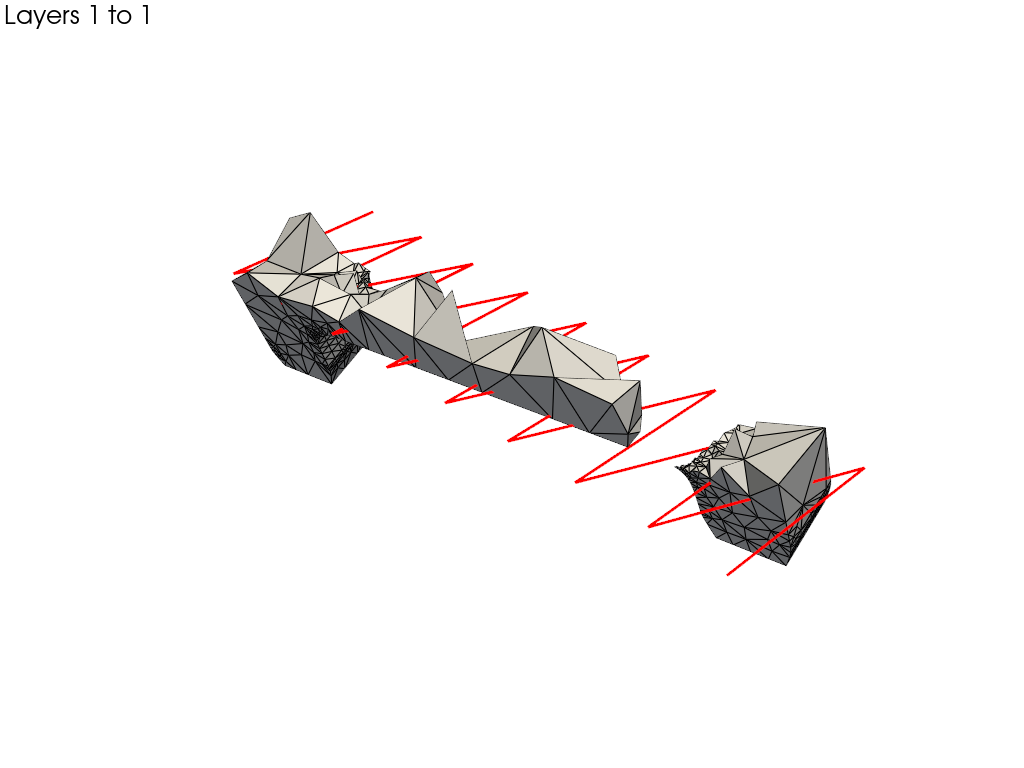

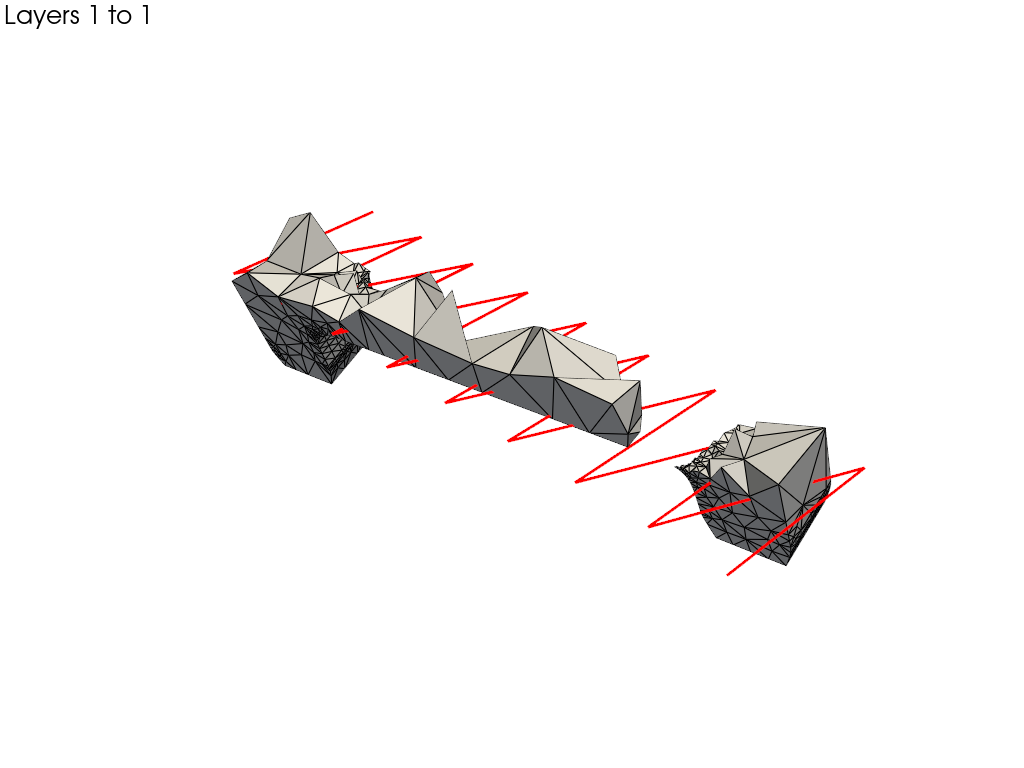

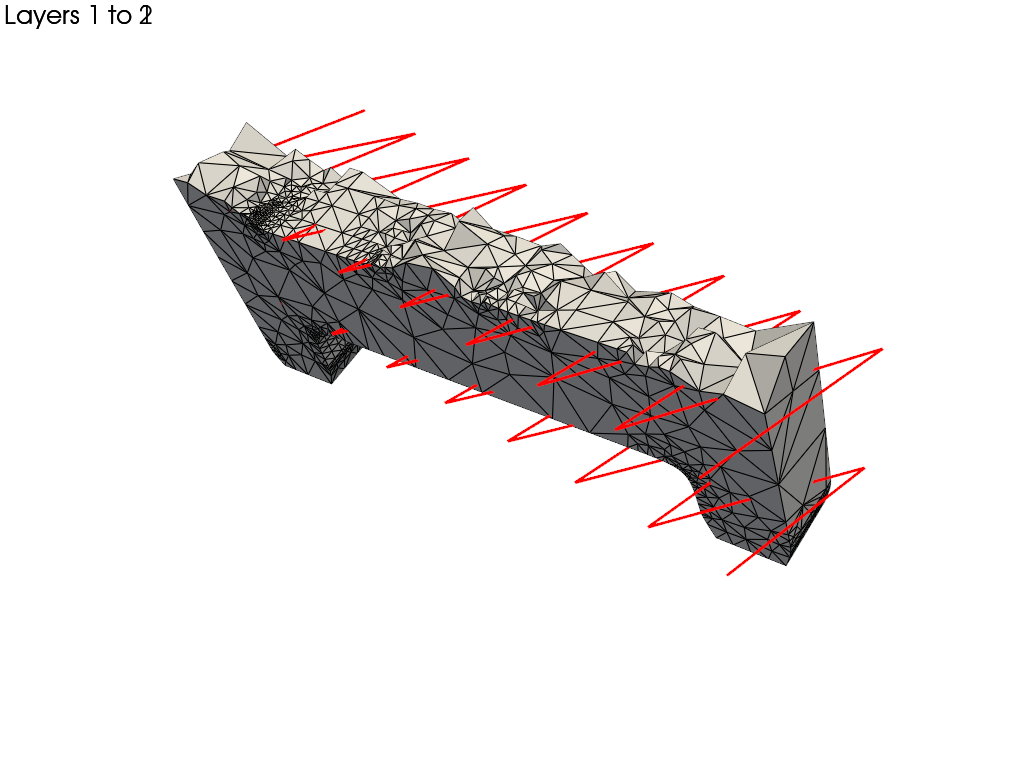

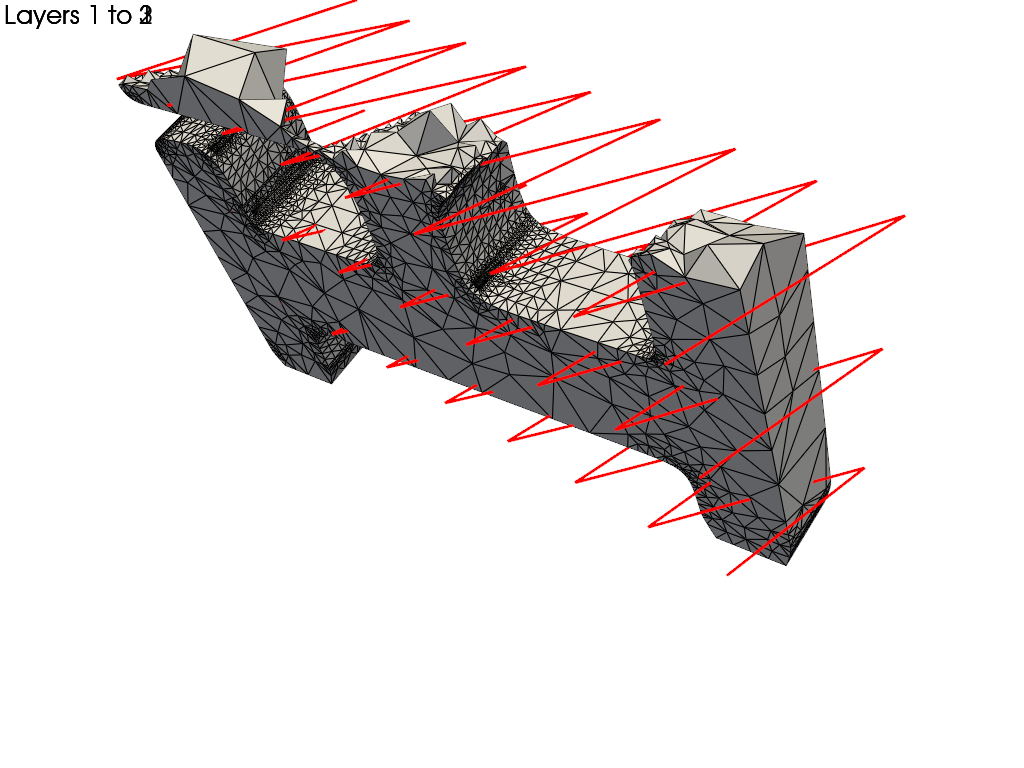

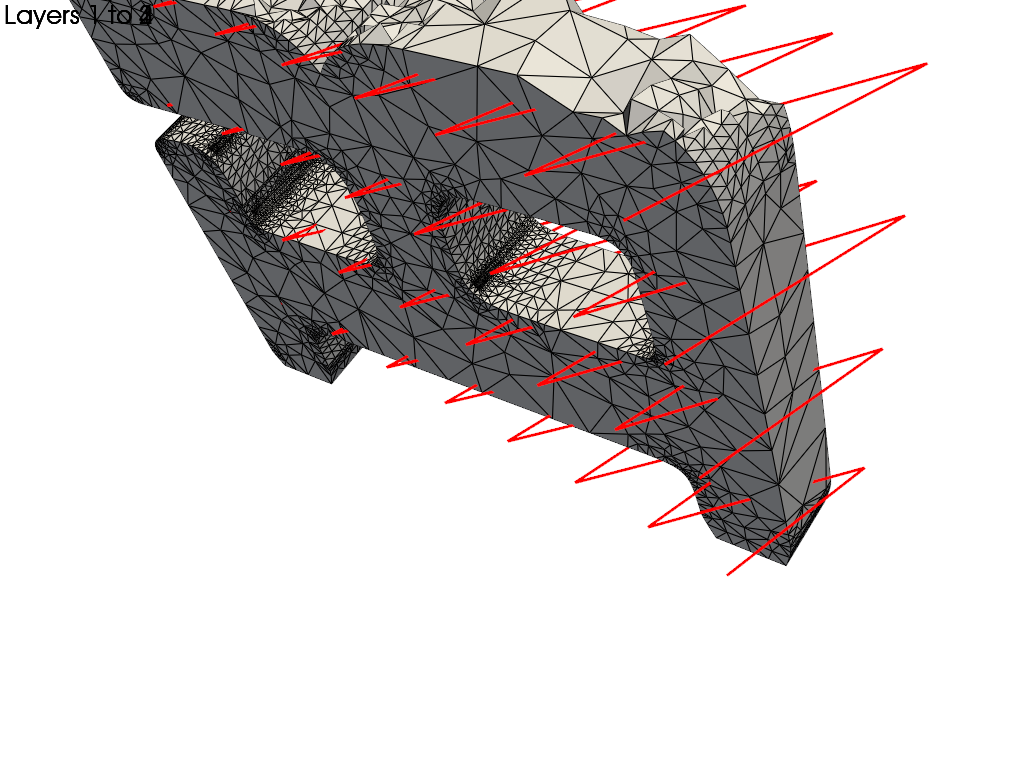

In [12]:
import pyvista as pv
from dolfinx.plot import vtk_mesh
import numpy as np

# Convert Dolfinx mesh to PyVista UnstructuredGrid
topology, cell_types, geometry = vtk_mesh(domain_mesh)
grid = pv.UnstructuredGrid(topology, cell_types, geometry)

# Layer settings
layer_thickness = 0.15  # Thickness of each layer
z_min, z_max = geometry[:, 2].min(), geometry[:, 2].max()
layers = np.arange(z_min, z_max, layer_thickness)

# Time-stepping parameters
velocity_x = 0.05  # Heat source velocity in x-direction (m/s)
dt = 0.1          # Time step size (s)
y_step = 0.1      # Spacing between heat source passes in the y-direction (m)

# PyVista Plotter
plotter = pv.Plotter()

# Combine layers progressively
for num_layers in range(1, len(layers) + 1):
    # Combine the first `num_layers` layers
    combined_filter = np.zeros(geometry.shape[0], dtype=bool)
    for i in range(num_layers):
        layer_z = layers[i]
        layer_filter = np.logical_and(
            geometry[:, 2] >= layer_z,
            geometry[:, 2] < layer_z + layer_thickness
        )
        combined_filter = np.logical_or(combined_filter, layer_filter)

    # Extract combined points and cells
    combined_indices = np.where(combined_filter)[0]
    combined_grid = grid.extract_points(combined_indices)

    # Calculate minX, maxX, minY, maxY for the combined layers
    combined_points = geometry[combined_indices]
    minX = combined_points[:, 0].min()
    maxX = combined_points[:, 0].max()
    minY = combined_points[:, 1].min()
    maxY = combined_points[:, 1].max()
    minZ = combined_points[:, 2].min()
    maxZ = combined_points[:, 2].max()

    # Total time required to traverse minX to maxX
    distance_x = maxX - minX
    total_time_x = distance_x / velocity_x
    num_steps_x = int(total_time_x / dt)

    # Generate grid lines in the y-direction
    y_positions = np.arange(minY, maxY + y_step, y_step)

    # Trace the heat source path for the combined layers
    path_points = []
    for y in y_positions:
        for step in range(num_steps_x):
            t = step * dt
            x_position = minX + velocity_x * t
            if x_position > maxX:
                x_position = maxX  # Stop at maxX
            path_points.append([x_position, y, maxZ])  # Current z-layer height

    # Convert the path to a PyVista line
    path_points = np.array(path_points)
    line = pv.lines_from_points(path_points)

    # Add the combined layers and the heat source path to the plotter
    plotter.add_mesh(
        combined_grid,
        show_edges=True,
        color="white",
        label=f"Layers 1 to {num_layers}"
    )
    plotter.add_mesh(
        line,
        color="red",
        line_width=3,
        label="Heat Source Path"
    )
    plotter.add_text(f"Layers 1 to {num_layers}", position="upper_left", font_size=10)

    # Show the combined layers with the heat source path
    plotter.show()



In [13]:
def moving_gaussian_heat_source(x, t, z_layer, minX, maxX, minY, maxY, velocity_x, y_step):
    """
    Moving Gaussian heat source along a grid of parallel lines in x-y directions.
    - Moves along x at each y-line (parallel lines).
    - Progresses along y in steps to form a grid pattern.
    """
    # Calculate the current y-line based on time
    total_time_x = (maxX - minX) / velocity_x  # Time to traverse one x-line
    num_y_lines = int((maxY - minY) / y_step) + 1
    y_line_index = int(t // total_time_x) % num_y_lines  # Current y-line (wraps around)
    local_time_x = t % total_time_x  # Time within the current x-line traversal

    # Current x position of the heat source
    x_position = minX + velocity_x * local_time_x
    if x_position > maxX:
        x_position = maxX  # Clamp to maxX if it overshoots

    # Current y position of the heat source
    y_position = minY + y_line_index * y_step
    if y_position > maxY:
        y_position = maxY  # Clamp to maxY if it overshoots

    # Center of the heat source
    center = np.array([x_position, y_position, z_layer])

    # Gaussian profile
    intensity = 1e6  # Heat intensity (W/m^3)
    radius = 0.1  # Laser radius (m)
    r = np.linalg.norm(x - center[:, np.newaxis], axis=0)  # Distance from the laser center
    return intensity * np.exp(-r**2 / (2 * radius**2))  # Gaussian profile


Simulating layer 1/4 at z = 0.0
Heat source max: 998138.7032482196, min: 3.807120477265194e-10
Max Temperature: 100.43300386270161
Min Temperature: 98.29223065605633


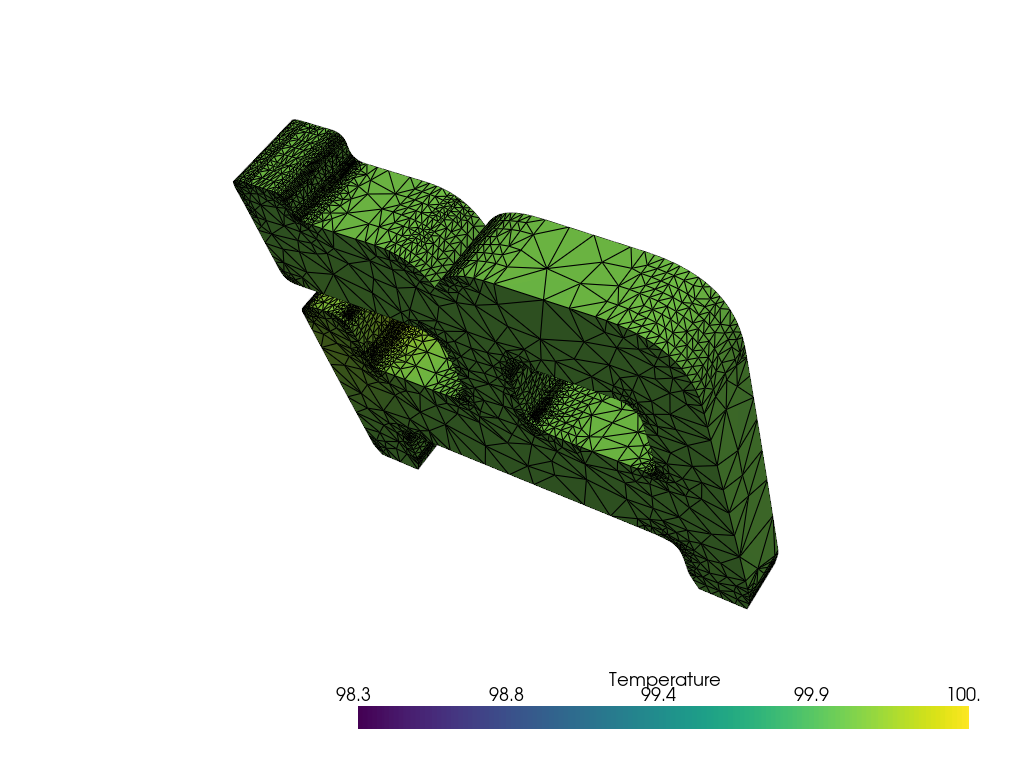

Layer 1 completed.
Simulating layer 2/4 at z = 0.15
Heat source max: 998144.8140107754, min: 6.013343021698917e-13
Max Temperature: 100.6294028431385
Min Temperature: 98.29819114389291


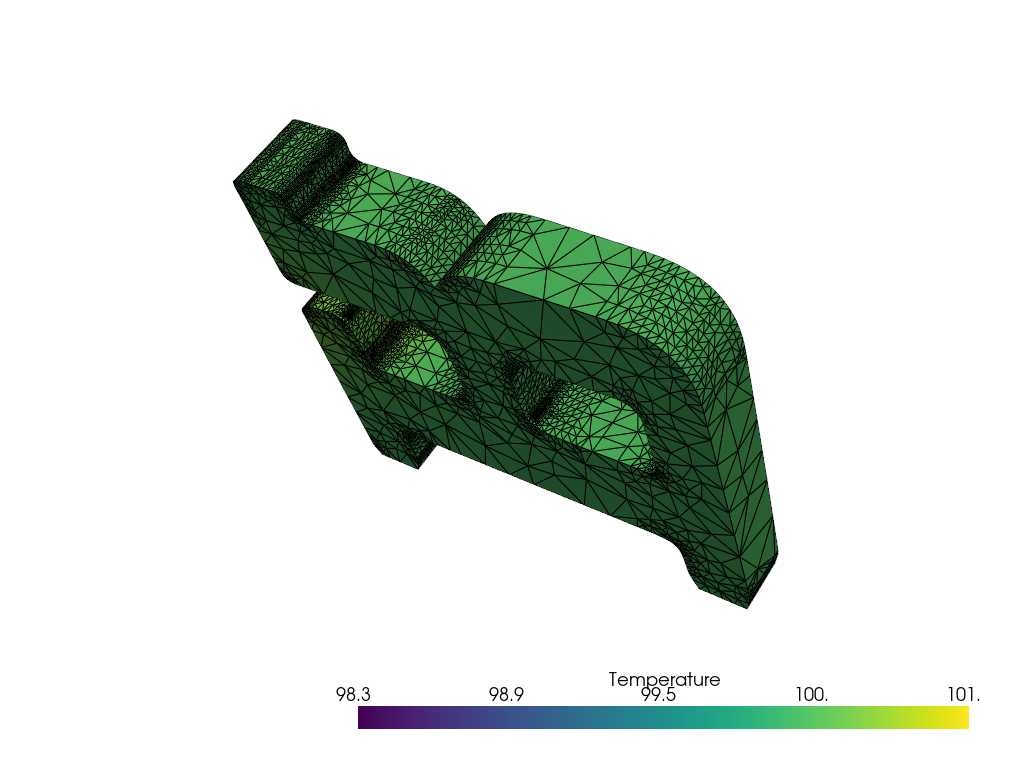

Layer 2 completed.
Simulating layer 3/4 at z = 0.3
Heat source max: 999210.7822470787, min: 9.68558405747479e-17
Max Temperature: 100.66844713691778
Min Temperature: 98.66937502255011


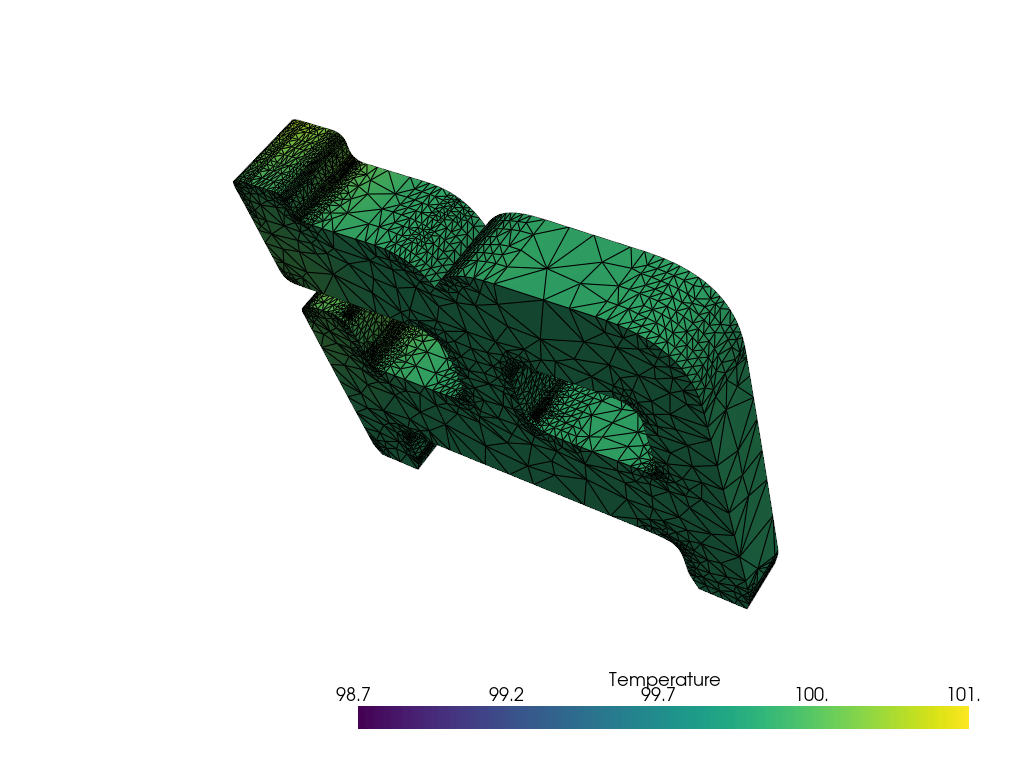

Layer 3 completed.
Simulating layer 4/4 at z = 0.44999999999999996
Skipping layer 4: no points found.


In [14]:
import numpy as np
import ufl
from dolfinx import fem
from dolfinx.fem.petsc import LinearProblem
from dolfinx.plot import vtk_mesh
from ufl import grad, dot

layer_height = 0.15
# Layer-by-layer simulation
num_layers = int((geometry[:, 2].max() - geometry[:, 2].min()) / layer_height)
for layer in range(num_layers):
    z_layer = layer * layer_height  # Current layer height
    print(f"Simulating layer {layer + 1}/{num_layers} at z = {z_layer}")

    # Define active layer subdomain
    def active_layer_subdomain(x):
        return np.logical_and(x[2] >= z_layer, x[2] < z_layer + layer_height)

    active_cells = locate_entities(domain_mesh, domain_mesh.topology.dim, active_layer_subdomain)
    dx_layer = ufl.Measure("dx", domain=domain_mesh, subdomain_data=active_cells)

    layer_indices = np.where(active_layer_subdomain(geometry.T))[0]
    if layer_indices.size == 0:
        print(f"Skipping layer {layer + 1}: no points found.")
        continue  # Skip this layer if no points are found

    # Extract bounds for x and y directions for the active layer
    layer_points = geometry[np.where(active_layer_subdomain(geometry.T))[0]]
    minX, maxX = layer_points[:, 0].min(), layer_points[:, 0].max()
    minY, maxY = layer_points[:, 1].min(), layer_points[:, 1].max()

    
    # Time-stepping within the layer
    for step in range(num_steps_per_layer):
        t = step * dt  # Time within the layer

        # Update the heat source for the current time step
        Q = fem.Function(V_T)
        Q.interpolate(lambda x: moving_gaussian_heat_source(
            x, t, z_layer, minX, maxX, minY, maxY, velocity_x, y_step
        ))

        # Define weak forms
        a_T = (rho * cp / dt) * T * v_T * dx_layer + k * dot(grad(T), grad(v_T)) * dx_layer
        L_T = (rho * cp / dt) * T_prev * v_T * dx_layer + Q * v_T * dx_layer

        # Solve for temperature
        temp_problem = LinearProblem(a_T, L_T, bcs=[bc_T])
        T_sol = temp_problem.solve()

        # Update T_prev for the next time step
        T_prev.x.array[:] = T_sol.x.array[:]

    # After finishing the layer, update T_prev for the next layer
    T_prev.x.array[:] = T_sol.x.array[:]
    print(f"Heat source max: {Q.x.array.max()}, min: {Q.x.array.min()}")
    print(f"Max Temperature: {T_sol.x.array.max()}")
    print(f"Min Temperature: {T_sol.x.array.min()}")

    # Save the solution for visualization (optional)
    topology, cell_types, geometry = vtk_mesh(domain_mesh)
    grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    grid.point_data["Temperature"] = T_sol.x.array
    grid.save(f"temperature_layer_{layer + 1}.vtk")
    import pyvista as pv

    plotter = pv.Plotter()
    plotter.add_mesh(grid, show_edges=True, scalars="Temperature", cmap="viridis")
    plotter.add_scalar_bar(title="Temperature")
    plotter.show()


    print(f"Layer {layer + 1} completed.")



Simulating layer 1/4 at z = 0.0


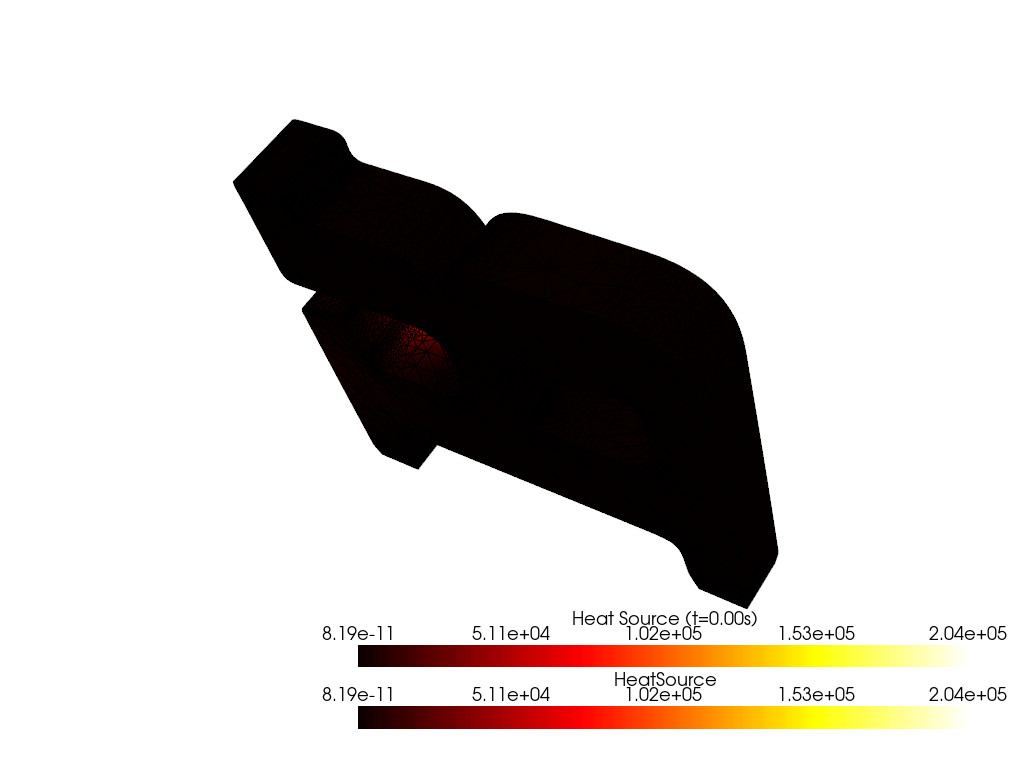

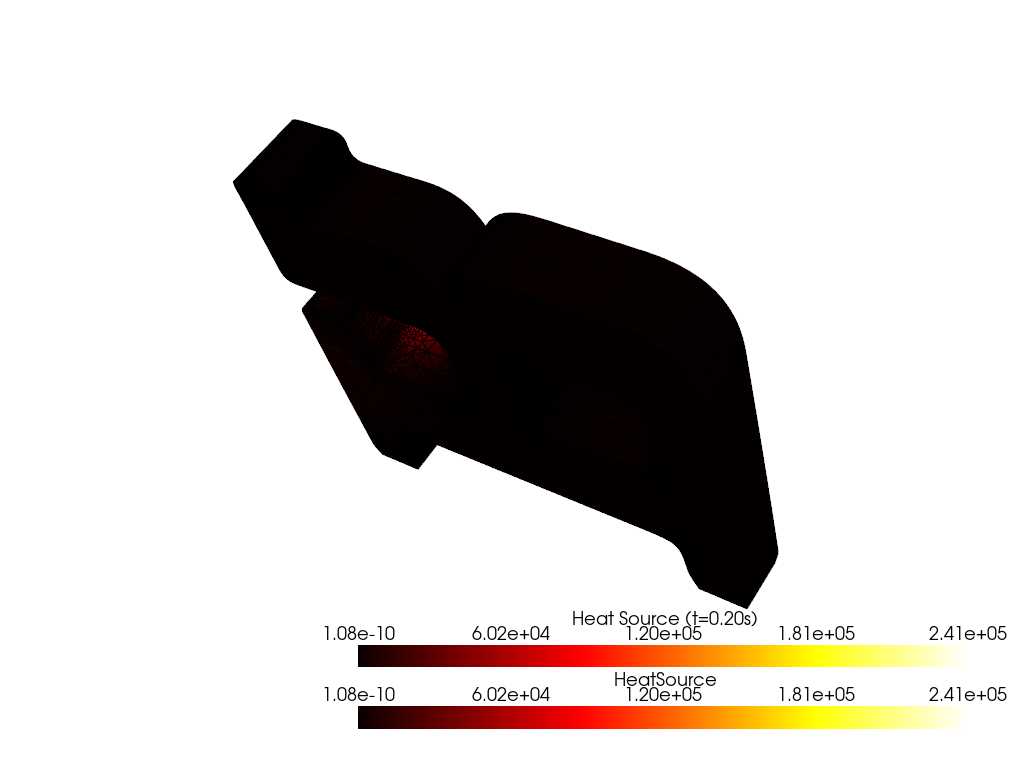

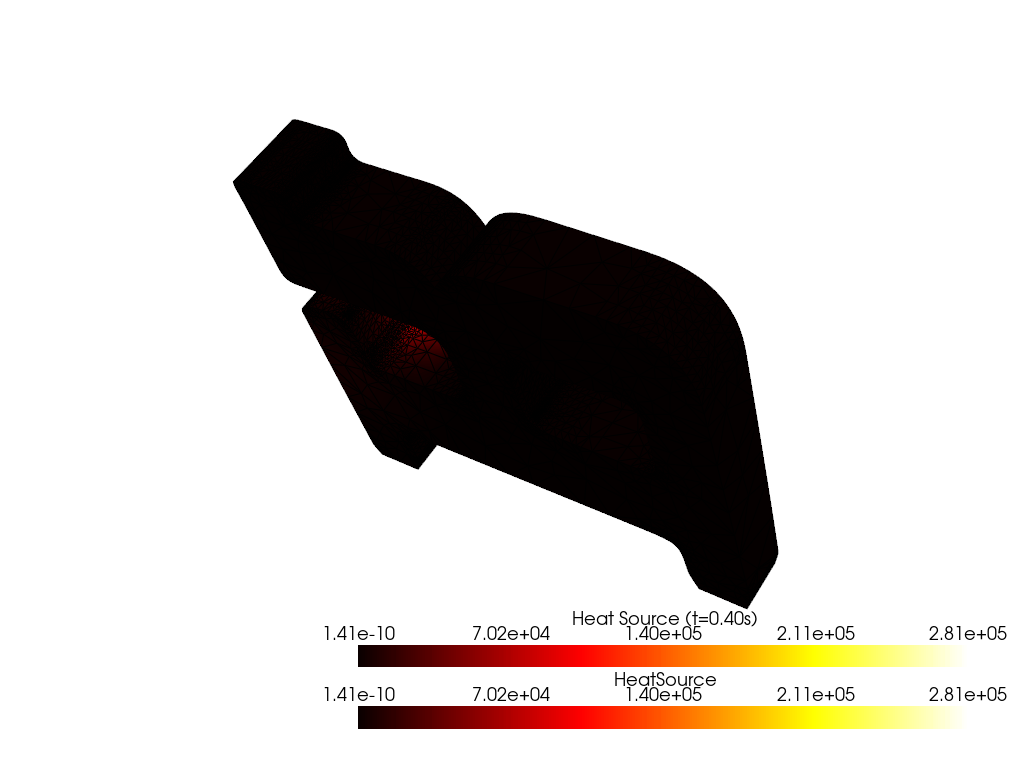

KeyboardInterrupt: 

In [18]:
import numpy as np
import ufl
from dolfinx import fem
from dolfinx.fem.petsc import LinearProblem
from dolfinx.plot import vtk_mesh
from ufl import grad, dot
import pyvista as pv
import random

layer_height = 0.15
# Layer-by-layer simulation

num_layers = int((geometry[:, 2].max() - geometry[:, 2].min()) / layer_height)
for layer in range(num_layers):
    z_layer = layer * layer_height  # Current layer height
    print(f"Simulating layer {layer + 1}/{num_layers} at z = {z_layer}")

    # Define active layer subdomain
    def active_layer_subdomain(x):
        return np.logical_and(x[2] >= z_layer, x[2] < z_layer + layer_height)

    active_cells = locate_entities(domain_mesh, domain_mesh.topology.dim, active_layer_subdomain)
    dx_layer = ufl.Measure("dx", domain=domain_mesh, subdomain_data=active_cells)

    layer_indices = np.where(active_layer_subdomain(geometry.T))[0]
    if layer_indices.size == 0:
        print(f"Skipping layer {layer + 1}: no points found.")
        continue  # Skip this layer if no points are found

    # Randomly sample 10 time steps within the layer time
    total_time_layer = num_steps_per_layer * dt
    random_times = sorted(random.sample(range(num_steps_per_layer), 10))  # Random time steps as indices

    # Loop over the randomly sampled time steps
    for step in random_times:
        t = step * dt  # Time for the current random step

        # Update the heat source for the current time step
        Q = fem.Function(V_T)
        Q.interpolate(lambda x: moving_gaussian_heat_source(
            x, t, z_layer, geometry[:, 0].min(), geometry[:, 0].max(),
            geometry[:, 1].min(), geometry[:, 1].max(), velocity_x, y_step
        ))

        # Visualize the entire object with the heat source applied
        full_grid = grid.copy()  # Use the entire grid for visualization
        full_grid.point_data["HeatSource"] = Q.x.array  # Assign heat source to all points

        # Plot the entire grid with the heat source
        plotter = pv.Plotter()
        plotter.add_mesh(full_grid, show_edges=True, scalars="HeatSource", cmap="hot")
        plotter.add_scalar_bar(title=f"Heat Source (t={t:.2f}s)")
        plotter.show()

    # Solve temperature field for the layer
    for step in range(num_steps_per_layer):
        t = step * dt  # Time within the layer

        # Define weak forms
        a_T = (rho * cp / dt) * T * v_T * dx_layer + k * dot(grad(T), grad(v_T)) * dx_layer
        L_T = (rho * cp / dt) * T_prev * v_T * dx_layer + Q * v_T * dx_layer

        # Solve for temperature
        temp_problem = LinearProblem(a_T, L_T, bcs=[bc_T])
        T_sol = temp_problem.solve()

        # Update T_prev for the next time step
        T_prev.x.array[:] = T_sol.x.array[:]

    # After finishing the layer, update T_prev for the next layer
    T_prev.x.array[:] = T_sol.x.array[:]
    print(f"Layer {layer + 1} completed.")


In [ ]:
#Todo: Implement the stress displacement off of the
#      temperature displacement that we now have